In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
# 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2011-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_76473/3789443377.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.droplevel(0, axis=1).resample('M').last()


In [3]:
# 수익률 데이터
ret = data.pct_change().dropna()

# 공분산 행렬
cov_mat = ret.cov() * 12

In [4]:
# 공분산 행렬 고윳값 분해
# 결국 기본적으로 공분산 행열의 경우, 역행열을 구하기 위해 고윳값 분해를 해야함
# 고윳값 행열과 고유벡터 분리 -> 고윳값 행열 처리. 다시 나중에 재 조립. 
w, v = np.linalg.eig(cov_mat)

In [5]:
v # 고유값 행열

array([[ 0.38714209,  0.08803802, -0.06201583,  0.31489867, -0.3574559 ,
         0.09680402, -0.16689875, -0.75685665,  0.03911845],
       [ 0.50162795, -0.78435849,  0.15622478, -0.31597296,  0.01525697,
         0.01658847,  0.0197322 ,  0.01620101,  0.088013  ],
       [ 0.38091412, -0.021429  , -0.10521105,  0.51661312, -0.29406025,
         0.15571955,  0.07841186,  0.53596313, -0.41516485],
       [ 0.36854775,  0.10990525, -0.02473314,  0.28036938,  0.78736599,
        -0.31242512, -0.21068021, -0.05013111, -0.09176454],
       [ 0.30937595,  0.3367454 , -0.31953048, -0.53047218, -0.04650406,
         0.27056717, -0.54578492,  0.17709397, -0.05268697],
       [ 0.18027568,  0.21033112,  0.37609002, -0.02295882, -0.37136356,
        -0.67357469, -0.22216281,  0.22982899,  0.29580271],
       [ 0.1268641 ,  0.27852132,  0.77858306, -0.1958316 ,  0.08139522,
         0.27186401,  0.11306854, -0.09719789, -0.39877642],
       [ 0.22820464,  0.20603233,  0.1400611 ,  0.18029412,  0

In [6]:
w # 고유 벡터

array([0.19699512, 0.03796718, 0.02048177, 0.01164279, 0.00251336,
       0.00385831, 0.00477066, 0.00654365, 0.00698344])

<Axes: xlabel='Ticker', ylabel='Ticker'>

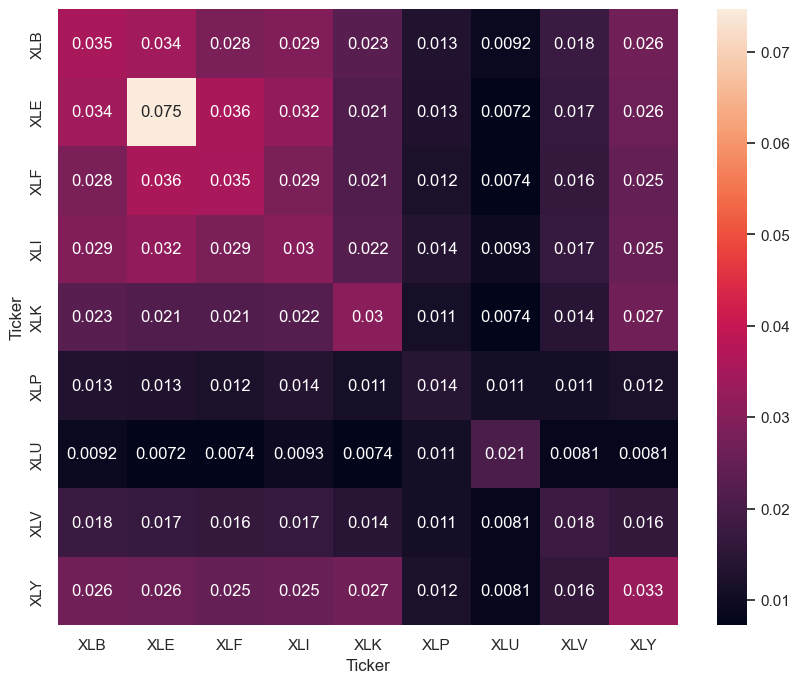

In [7]:
# 공분산 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cov_mat, annot=True)

In [8]:
# 공분산 행렬의 역행렬 계산 함수
def inverse_cov_mat(cov_mat, eps=0.05, is_plot=True):

    # 고윳값 분해
    w, v = np.linalg.eig(cov_mat)
    
    # 고윳값이 음수라면 0으로 치환
    if np.where(w >= 0, True, False).sum() != len(w): #만약 고유값 행열 w가 양수인 애들, 이 전체 개수와 다르다면 (즉 음수 존재하다면)
        w = np.where(w < 0, 0, w) # w 가 음수인애들은 0으로 바꿔라

    # 유의미하지 않는 고윳값을 0으로 처리
    weighted_w = w / np.sum(w) #0이 아닌 애들을 다 더해서 상대적 가중치 ()
    noise_free_w = np.where(weighted_w >= eps, w, 0) # 이게 우리가 설정한 eps 0.05 보다 크거나 같다면 w, 아니면 0으로

    # 고윳값과 상대적 가중치에 대한 그래프 생성
    if is_plot:
        plt.plot(np.sort(w)[::-1], marker='o', label='eigenvalue')
        plt.plot(np.sort(noise_free_w)[::-1], marker='x', label='updated eigenvalue')
        plt.legend()
        plt.show()

    # 역행렬 계산
    inv_mat = v @ np.diag(np.where(noise_free_w != 0, 1 / noise_free_w, 0)) @ v.T
    #고유벡터 v x 수정된 고유값이 0이아니라면 역수 처리, 0이면 0,X V(transpose)
    new_cov_mat = v @ np.diag(noise_free_w) @ v.T

    return inv_mat, new_cov_mat

In [12]:
inv_mat

array([[ 1.15274286e+00, -1.30597283e+00,  1.01746099e+00,
         1.05401953e+00,  2.35633197e+00, -2.96747654e-01,
        -1.46228599e+00,  5.02137639e-01,  2.27936790e+00],
       [-1.30597283e+00,  1.86728966e+01,  6.10159691e-01,
        -1.52069934e+00, -8.60620015e+00, -1.01751742e+00,
         5.07761998e-01, -2.60697511e+00, -7.49850526e+00],
       [ 1.01746099e+00,  6.10159691e-01,  1.28908843e+00,
         7.77650210e-01,  2.04952332e+00, -1.70203265e+00,
        -3.91133004e+00, -3.94492865e-01,  2.05395363e+00],
       [ 1.05401953e+00, -1.52069934e+00,  7.77650210e-01,
         1.03751096e+00,  1.93944160e+00,  4.91968306e-01,
         1.03398522e-01,  8.54213314e-01,  1.86797721e+00],
       [ 2.35633197e+00, -8.60620015e+00,  2.04952332e+00,
         1.93944160e+00,  8.45749906e+00, -3.71865349e+00,
        -9.47691526e+00,  7.13586883e-04,  7.85903996e+00],
       [-2.96747654e-01, -1.01751742e+00, -1.70203265e+00,
         4.91968306e-01, -3.71865349e+00,  8.236006

In [11]:
new_cov_mat

array([[0.02989848, 0.03543651, 0.02911246, 0.02850611, 0.02512604,
        0.01397408, 0.00961733, 0.01791482, 0.02791641],
       [0.03543651, 0.07342798, 0.03794277, 0.03306714, 0.01952133,
        0.01275429, 0.00673344, 0.01686333, 0.02466085],
       [0.02911246, 0.03794277, 0.02882727, 0.02761905, 0.0236296 ,
        0.012546  , 0.00761528, 0.01665462, 0.02653108],
       [0.02850611, 0.03306714, 0.02761905, 0.02722848, 0.02402838,
        0.01377554, 0.0099784 , 0.01735692, 0.02665593],
       [0.02512604, 0.01952133, 0.0236296 , 0.02402838, 0.02525165,
        0.0112148 , 0.0061973 , 0.0156256 , 0.02695457],
       [0.01397408, 0.01275429, 0.012546  , 0.01377554, 0.0112148 ,
        0.01097886, 0.01272698, 0.01082853, 0.01239581],
       [0.00961733, 0.00673344, 0.00761528, 0.0099784 , 0.0061973 ,
        0.01272698, 0.01853168, 0.01011545, 0.007013  ],
       [0.01791482, 0.01686333, 0.01665462, 0.01735692, 0.0156256 ,
        0.01082853, 0.01011545, 0.01227246, 0.01709055],


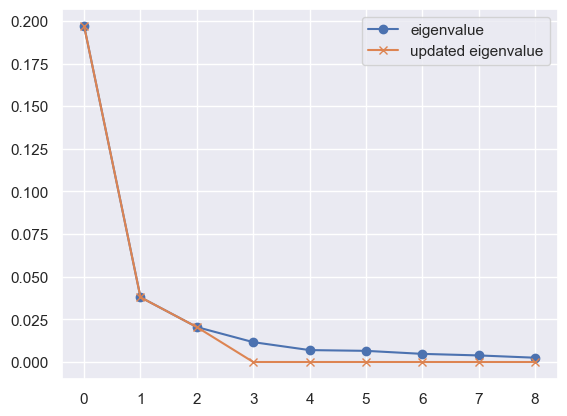

/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_76473/2254842556.py:23: RuntimeWarning: divide by zero encountered in divide
  inv_mat = v @ np.diag(np.where(noise_free_w != 0, 1 / noise_free_w, 0)) @ v.T


In [9]:
# 업데이트된 공분산 행렬
inv_mat, new_cov_mat = inverse_cov_mat(cov_mat)

<Axes: >

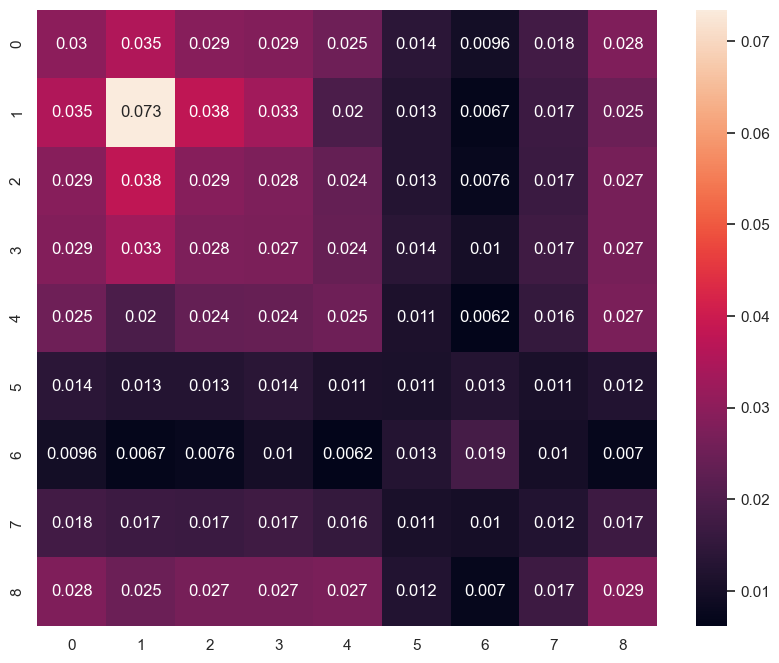

In [10]:
# 공분산 행렬 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(new_cov_mat, annot=True)